In [30]:
import os
import warnings

import act
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates
import pandas as pd

import numpy as np
import pyart
import xarray as xr

import cartopy.feature as cfeature
from scipy.spatial import cKDTree
import pandas as pd
from wrf import (getvar, CoordPair, vertcross, latlon_coords, to_np, destagger)
import glob
from netCDF4 import Dataset

warnings.filterwarnings("ignore")

In [31]:
path_head = '/data/home/ajmal13/blimp/scripts/bnfceilpblhtM1.a0/'
ds_ceil = xr.open_mfdataset(os.path.join(path_head+'*.nc'))

In [32]:
start_plot_date = '2025-04-04T00:00:00'
end_plot_date = '2025-04-04T23:59:59'
ds_ceil_plot=ds_ceil.sel(time=slice(start_plot_date,end_plot_date))

In [33]:
bl_height_1=np.transpose(ds_ceil_plot.bl_height_1.values)
bl_height_2=np.transpose(ds_ceil_plot.bl_height_2.values)
bl_height_3=np.transpose(ds_ceil_plot.bl_height_3.values)
timestamps = ds_ceil_plot.time.values

In [34]:
path_head = '/data/project/ARM_Summer_School_2025/model/wrf/'
case_day = '2025040406/'

In [35]:
ds_wrf = xr.open_mfdataset(os.path.join(path_head+case_day+'run/wrfout_d01*'),concat_dim='Time',combine='nested')

In [36]:
# Pull static lat/lon at first time step
lat2d = ds_wrf['XLAT'].isel(Time=0)
lon2d = ds_wrf['XLONG'].isel(Time=0)

# Flatten and build KDTree
flat_coords = np.column_stack((lat2d.values.ravel(), lon2d.values.ravel()))
tree = cKDTree(flat_coords)

# ARM site locations
target_lat = [34.3425, 34.6538, 34.3848, 34.1788]
target_lon = [-87.3382, -87.2927, -86.9279, -87.4539]
target_coords = np.column_stack((target_lat, target_lon))

# Find nearest indices
_, flat_idx = tree.query(target_coords)
i_indices, j_indices = np.unravel_index(flat_idx, lat2d.shape)

# Create dict of site names to datasets
site_names = ['M1', 'S20', 'S30', 'S40']
site_datasets = {}

for name, i, j in zip(site_names, i_indices, j_indices):
    site_datasets[name] = ds_wrf.isel(south_north=i, west_east=j).expand_dims(site=[name])

In [37]:
ds_wrf_bnf_site = xr.concat(site_datasets.values(), dim='site')

In [43]:
ds_ceil_hourly_avg = ds_ceil.resample(time='15min').mean()
ds_ceil_hourly_avg

<xarray.Dataset> Size: 74kB
Dimensions:           (time: 768)
Coordinates:
  * time              (time) datetime64[ns] 6kB 2025-04-04 ... 2025-04-11T23:...
Data variables: (12/14)
    sample_count      (time) float64 6kB dask.array<chunksize=(1,), meta=np.ndarray>
    bl_height_1       (time) float32 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    bl_index_1        (time) float64 6kB dask.array<chunksize=(1,), meta=np.ndarray>
    bl_height_2       (time) float32 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    bl_index_2        (time) float64 6kB dask.array<chunksize=(1,), meta=np.ndarray>
    bl_height_3       (time) float32 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    ...                ...
    first_cbh         (time) float32 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    second_cbh        (time) float32 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    third_cbh         (time) float32 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    lat               (time) float64 6kB 34.34 34.34 34.34 ... 34.34 34.34 34.34
    lon               (time) float64 6kB -87.34 -87.34 -87.34 ... -87.34 -87.34
    alt               (time) float64 6kB 293.0 293.0 293.0 ... 293.0 293.0 293.0
Attributes: (12/16)
    command_line:          ceilpblht_ingest -s bnf -f M1 --max-runtime 0
    Conventions:           ARM-1.3
    process_version:       ingest-ceilpblht-1.5-0.el9
    dod_version:           ceilpblht-a0-2.0
    input_source:          /data/collection/bnf/bnfceilpblhtM1.00/L3_DEFAULT_...
    site_id:               bnf
    ...                    ...
    datastream:            bnfceilpblhtM1.a0
    data_update_period:    0
    averaging_interval:    data_update_period * sample_count
    algorithm_parameters:  height_averaging_flag = 1\nmax_height_averaging_va...
    doi:                   10.5439/1095593
    history:               created by user armflowprod on machine prod-slurmn...

In [46]:
start_plot_date = '2025-04-04T00:00:00'
end_plot_date = '2025-04-04T23:59:59'
ds_ceil_plot_hourly=ds_ceil_hourly_avg.sel(time=slice(start_plot_date,end_plot_date))

In [48]:
bl_height_1=np.transpose(ds_ceil_plot_hourly.bl_height_1.values)
bl_height_2=np.transpose(ds_ceil_plot_hourly.bl_height_2.values)
bl_height_3=np.transpose(ds_ceil_plot_hourly.bl_height_3.values)

timestamps = ds_ceil_plot_hourly.time.values



## Compare WRF Simulation results with Ceilometer PBL

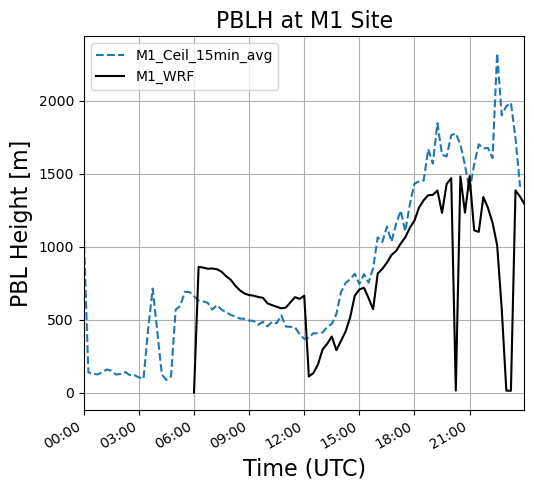

In [49]:
# Select the variables you want to plot
var1a = ds_wrf_bnf_site['PBLH'] # surface sensible heat flux
#var1b = ds_wrf_bnf_site['LH'] # surface latent heat flux


# Make the plot
plt.figure(figsize=(10, 5))
cols = ['k','gray','b','lightskyblue']

######################## Subplot 1 ########################
# Sensible and latent heat fluxes
ax=plt.subplot(1,2,1)
count = 0
plt.plot(timestamps,bl_height_1, label='M1_Ceil_15min_avg',linestyle='dashed')
#for site in var1a.site.values:
plt.plot(var1a['XTIME'], var1a.sel(site='M1'), color='black', label='M1_WRF')
#    plt.plot(var1b['XTIME'], var1b.sel(site=site), c=cols[count], ls='--')
    
#    count+=1

plt.xlabel("Time (UTC)",fontsize=16)
plt.ylabel("PBL Height [m]",fontsize=16)
plt.title("PBLH at M1 Site",fontsize=16)
plt.legend()
plt.grid(True)
plt.xlim([pd.Timestamp(2025,4,4,0),pd.Timestamp(2025,4,4,23,59,0)])
#hours = mdates.HourLocator(interval = 3)
#h_fmt = mdates.DateFormatter('%H:%M')
#ax.xaxis.set_major_locator(hours)
#ax.xaxis.set_major_formatter(h_fmt)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gcf().autofmt_xdate() # clean up labels


plt.tight_layout()
plt.show()

## Findings

1. The ceilometer and WRF PBLH values agree with eachother resonably well

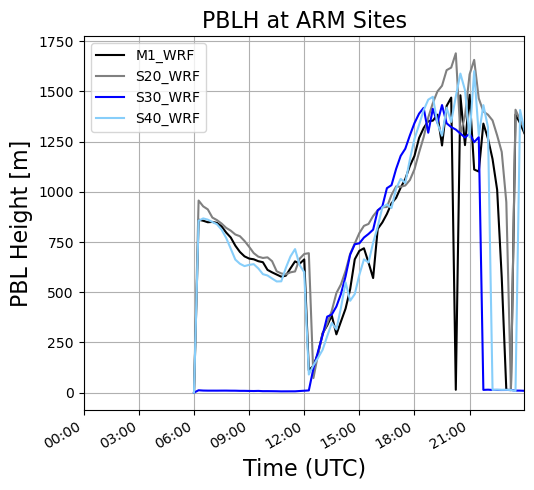

In [42]:
# Select the variables you want to plot
var1a = ds_wrf_bnf_site['PBLH'] # surface sensible heat flux
#var1b = ds_wrf_bnf_site['LH'] # surface latent heat flux


# Make the plot
plt.figure(figsize=(10, 5))
cols = ['k','gray','b','lightskyblue']

######################## Subplot 1 ########################
# Sensible and latent heat fluxes
ax=plt.subplot(1,2,1)
count = 0
for site in var1a.site.values:
    plt.plot(var1a['XTIME'], var1a.sel(site=site), c=cols[count], label=site+'_WRF')
#    plt.plot(var1b['XTIME'], var1b.sel(site=site), c=cols[count], ls='--')
    
    count+=1

plt.xlabel("Time (UTC)",fontsize=16)
plt.ylabel("PBL Height [m]",fontsize=16)
plt.title("PBLH at ARM Sites",fontsize=16)
plt.legend()
plt.grid(True)
plt.xlim([pd.Timestamp(2025,4,4,0),pd.Timestamp(2025,4,4,23,59,0)])
#hours = mdates.HourLocator(interval = 3)
#h_fmt = mdates.DateFormatter('%H:%M')
#ax.xaxis.set_major_locator(hours)
#ax.xaxis.set_major_formatter(h_fmt)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gcf().autofmt_xdate() # clean up labels


plt.tight_layout()
plt.show()